In [102]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import gridspec

In [103]:
#load dataset
data = pd.read_csv("C:/Users/thoma/PycharmProjects/pythonProject3/creditcard.csv")

In [104]:
# get the shape of the data frame
print(data.shape)

(284807, 31)


In [105]:
# create labels
labels=["Valid","Fraud"]

# get count list
li = data["Class"].value_counts().tolist()
values = [li[0], li[1]]

# plot data
fig = px.pie(values=data['Class'].value_counts(),names=labels ,width=600,
             height=400,color_discrete_sequence=["orange","blue"],
             title="Fraud vs Valid transactions")
fig.show()

In [106]:
# data has a class imbalance since there are
# many more valid than fraudulent transactions
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

print(f"Fraud Cases: {len(data[data['Class'] == 1])}")
print(f"Valid Transactions: {len(data[data['Class'] == 0])}")

Fraud Cases: 492
Valid Transactions: 284315


In [107]:
#the amount details for fraudulent transaction
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [108]:
#the amount details for normal transaction
valid.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

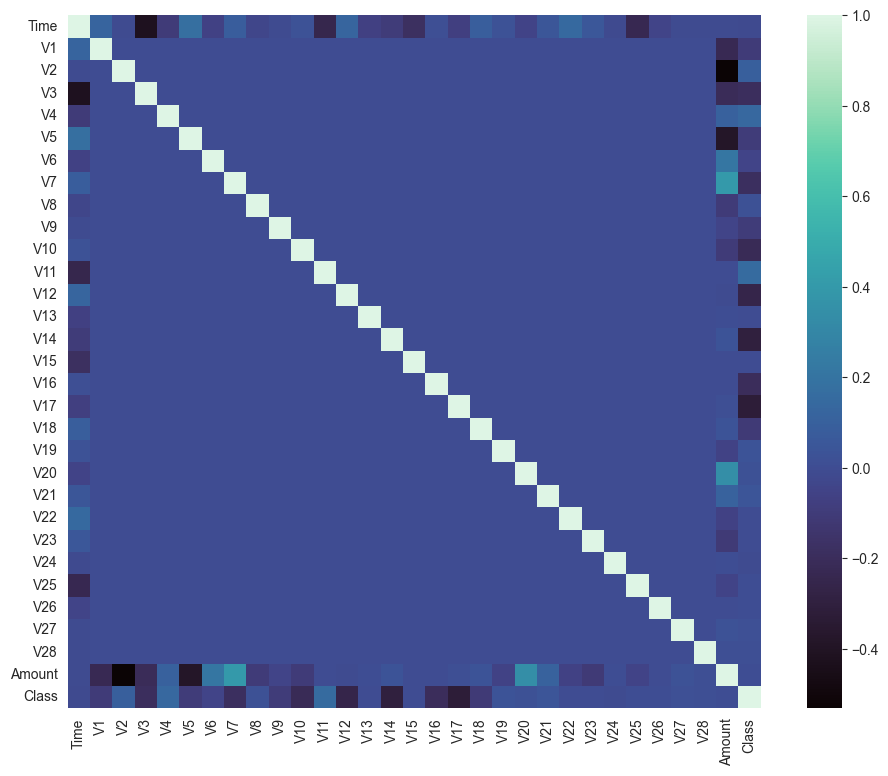

In [110]:
#plotting the correlation matrix
corr = data.corr()
# could use abs value for correlation as we can treat negatively and positively correlated as both being important
#corr = data.corr().abs()
fig = plt.figure(figsize = (12, 9))
sns.color_palette("mako", as_cmap=True)
sns.heatmap(corr, cmap="mako", square = True)
plt.show()

In [ ]:
"""colors = ['#C4C7DF','#4C4C4C', "blue"]
mat = corr.unstack()
mat = mat[mat.between(0.1, 1, inclusive='neither')]

print(mat['Class'])
corr = data.corrwith(data['Class']).sort_values(ascending = False)

corr.columns = ['Correlation']
res = []
for i in range(len(corr)):
    print(type(corr.iloc[i]))
    #if corr.iloc[i] > 0.1 or corr.iloc[i] < -0.1:
    #res.append(corr.iloc[i])



#corr = [x for x in corr if x > 0.1 or x < -0.1]

#fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,6))


#plt.subplot(1,2,1)
#sns.heatmap(corr.iloc[:15,:],annot = True, cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False)
#plt.title('First Half')

#plt.subplot(1,2,2)
#sns.heatmap(corr.iloc[15:30],annot = True, cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False)
#plt.title('Second Half')

#fig.tight_layout(w_pad = 1)"""

In [111]:
#separating the X and the Y values
X = data.drop(['Class'], axis = 1)

# only use the features with an abs value correlation above a certain threshold, we have to decide what matters and doesn't even a weak correlation could be useful
#X = data[['V3','V4','V7','V10','V11','V12','V14','V16','V17']].copy(deep = True)
Y = data["Class"]
print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing
# (its a numpy array with no columns)
xData = X.values
yData = Y.values

(284807, 30)
(284807,)


In [112]:
#training and testing data bifurcation
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
# for later, don't run SMOTE on test data, only training.
xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, test_size = 0.2, random_state = 42)

In [ ]:
"""
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
def class_imbalance(data, _x, _y, sampling_methods={'SMOTE': SMOTE(), 'Near-Miss': NearMiss(),
                                            'over': RandomOverSampler(sampling_strategy=0.5),
                                            'under':RandomUnderSampler(sampling_strategy=0.8)}):

    #Testing SMOTE() and Near-Miss() Algorithms
    sampling_alg = [sampling_methods['SMOTE']]

    for alg in sampling_alg:
        X_new, y_new = alg.fit_resample(X, _y)
        bal = y_new.value_counts(normalize=True) * 100

        print(f'''Shape of X before {alg}: {X.shape} Shape of X after {alg}: {X_new.shape}''')
        print(f'\nBalance of positive and negative classes (%): \n{bal}\n')

    ## Combined Sampling: Random Sampling Algorithms
    X_over, y_over = sampling_methods['over'].fit_resample(X, _y)
    X_sampled, y_sampled = sampling_methods['under'].fit_resample(X_over, y_over)

    bal = y_sampled.value_counts(normalize=True) * 100
    print(f'''After combined sampling, shape of features: {X_sampled.shape}''')
    print(f'\nBalance of positive and negative classes (%): \n{bal}\n')

    return X_sampled, y_sampled

xTrain, yTrain = class_imbalance(data, xTrain, yTrain)"""

In [113]:
# FYI, this cell might take a bit to finish loading,
# import classifier
from sklearn.ensemble import RandomForestClassifier

# create the classifier object, the more estimators
# the longer it will take to run, diminishing returns at a point
# later we will more finely tune the model's parameters along with
# prune certain lowly correlated items
rfc = RandomForestClassifier(n_estimators = 100, random_state = 13)

# train the data
rfc.fit(xTrain, yTrain)

# get predictions
yPred = rfc.predict(xTest)

In [125]:
#building all kinds of evaluating parameters
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, average_precision_score

# solve for accuracy, precision, recall, f1 score and auprc
results = {
    "Accuracy": accuracy_score(yTest, yPred),
    "Precision": precision_score(yTest, yPred),
    "Recall": recall_score(yTest, yPred),
    "F1 Score": f1_score(yTest, yPred),
    "AUPRC": average_precision_score(yTest, yPred),
}


________________________________
Random Forest Classifier Results
________________________________
Accuracy: 0.9995786664794073
Precision: 0.9743589743589743
Recall: 0.7755102040816326
F1 Score: 0.8636363636363635
AUPRC: 0.756011549447775


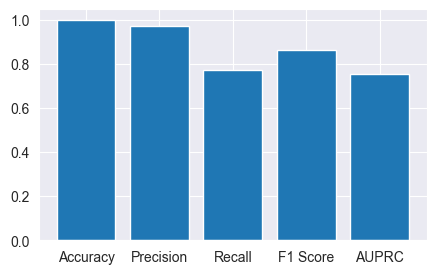

In [139]:
# show results
print("________________________________")
print("Random Forest Classifier Results")
print("________________________________")
for [k, v] in results.items():
    print(f"{k}: {v}")

vals = results.values()
names = results.keys()

fig = plt.figure(figsize = (5, 3))
plt.bar(names, vals)
plt.show()

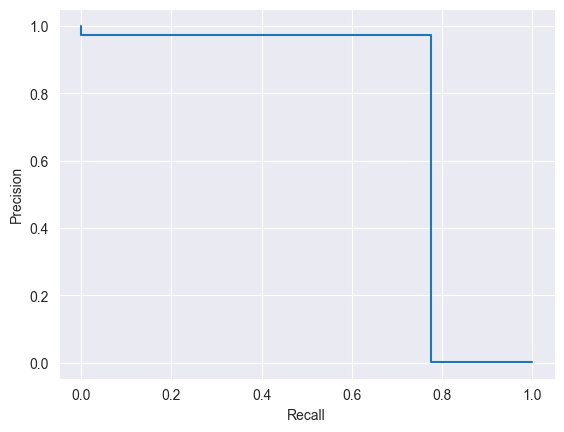

In [140]:

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

precision, recall, _ = precision_recall_curve(yTest, yPred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()